In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sqlite3
import taxis
from utils import *
from visualize import *
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from datetime import datetime
from sklearn.cluster import *
from sklearn.svm import *

DBNAME="../taxis.db"
LAT=1.380766
LON=103.891675
LAT1=1.303693
LON1=103.844952

In [2]:
holidays=['20170626']
def peak(h,m,w):
    return 1 if ((w==1 and (h>=6 and (h <=9 and m<30)) or (h >= 18))) else 0

def weekday(d):
    dt=datetime.strptime(d,"%Y%m%d")
    return 1 if datetime.isoweekday(dt)<6 else 0

df=taxis.get_df_all_taxi_data(DBNAME,LAT1,LON1)
df['Hour']=df.apply(lambda r:int(r['Time'][:2]),axis=1)
df['Minute']=df.apply(lambda r:int(r['Time'][2:]),axis=1)
df['Weekday']=df.apply(lambda r: weekday(r['Date']),axis=1)
df['Holiday']=df.apply(lambda r: 1 if r['Date'] in holidays else 0,axis=1)
df['PeakHour']=df.apply(lambda r: peak(r['Hour'],r['Minute'],r['Weekday']),axis=1)


In [3]:
df.tail()

,Point,Date,Time,X,Y,TaxiCount,Hour,Minute,Weekday,Holiday,PeakHour
4119,4119,20170708,2330,20,5,20,23,30,0,0,1
4120,4120,20170708,2335,20,5,18,23,35,0,0,1
4121,4121,20170708,2340,20,5,25,23,40,0,0,1
4122,4122,20170708,2345,20,5,28,23,45,0,0,1
4123,4123,20170708,2350,20,5,23,23,50,0,0,1


In [4]:
h=df.quantile(q=0.8)['TaxiCount']
l=df.quantile(q=0.2)['TaxiCount']

In [12]:
df_sub=df.query('(TaxiCount>=@l and TaxiCount<=@h) and (Hour>=6 and Hour<=12) and Weekday==1')[['Point','Hour','Minute','PeakHour','Weekday','Holiday','TaxiCount']]
df_sub.head()

,Point,Hour,Minute,PeakHour,Weekday,Holiday,TaxiCount
546,546,7,20,1,1,1,34
547,547,7,25,1,1,1,27
549,549,7,35,0,1,1,27
550,550,7,40,0,1,1,28
553,553,7,55,0,1,1,35


In [13]:
df_sub.corr()

,Point,Hour,Minute,PeakHour,Weekday,Holiday,TaxiCount
Point,1.000000,-0.072167,0.009375,0.028447,NaN,-0.529075,-0.104092
Hour,-0.072167,1.000000,-0.028213,-0.297722,NaN,0.188672,0.666692
Minute,0.009375,-0.028213,1.000000,-0.666322,NaN,-0.030309,-0.013066
PeakHour,0.028447,-0.297722,-0.666322,1.000000,NaN,-0.086593,-0.139808
Weekday,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Holiday,-0.529075,0.188672,-0.030309,-0.086593,NaN,1.000000,0.048145
TaxiCount,-0.104092,0.666692,-0.013066,-0.139808,NaN,0.048145,1.000000


In [14]:
f=df_sub['Point'].count()
c=int(f*0.8)
d=f-c
print c
print d
training=df_sub.head(c)
testing=df_sub.tail(d)

340
86


In [15]:
X=training.drop(['Point','TaxiCount'],axis=1).as_matrix()
y=np.array(training['TaxiCount'].tolist()).reshape(-1,1)

svc=SVC(kernel='rbf',gamma=2,C=2,probability=True).fit(X,y)
print svc

svc.score(X,y)
#plt.plot(y,color='g')
#plt.plot(svc.predict(X),color='r')
#plt.show()


SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


0.45000000000000001

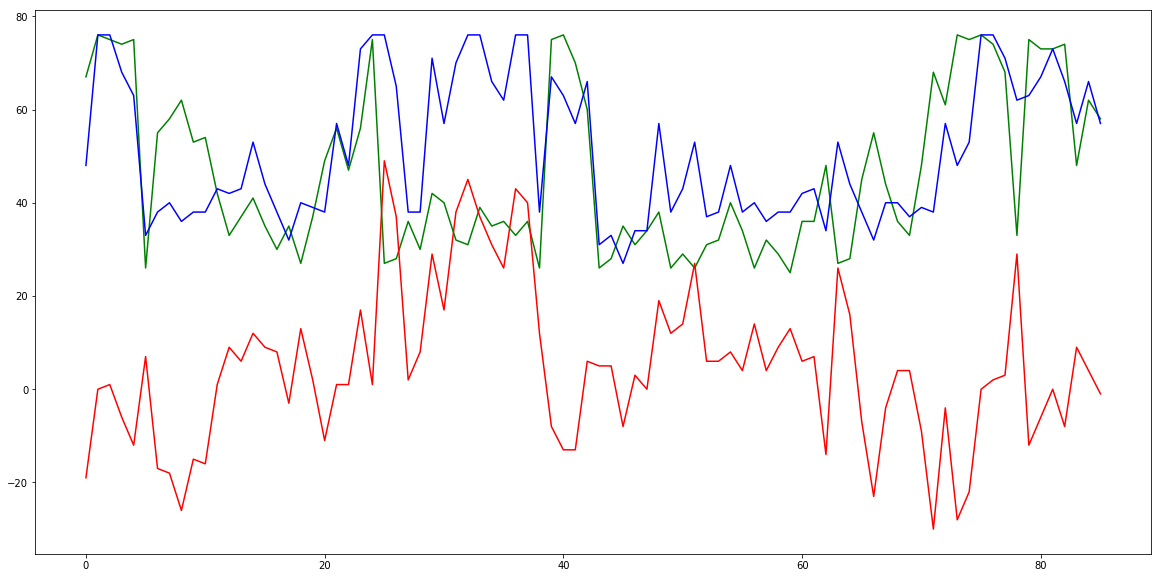

In [16]:
Xt=testing.drop(['Point','TaxiCount'],axis=1).as_matrix()
yt=np.array(testing['TaxiCount'].tolist()).reshape(-1,1)
P=svc.predict(Xt)
e=[x-y for x,y in zip(P,yt)]

plt.plot(yt,color='g')
plt.plot(P,color='b')
plt.plot(e,color='r')
plt.show()